# SETD2
SETD2 is the primary methyltransferase catalyzing H3K36 trimethylation (H3K36me3).
Pathogenic variants in SETD2 are observed in
[Intellectual developmental disorder, autosomal dominant 70	(OMIM:620157)](https://omim.org/entry/620157),
[Luscan-Lumish syndrome	(OMIM:616831)](https://omim.org/entry/616831), and
[Rabin-Pappas syndrome	(OMIM:620155)](https://omim.org/entry/620155).

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using gpsea version 0.9.2


### SETD2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SETD2.

In [2]:
gene_symbol = 'SETD2'
mane_tx_id = 'NM_014159.7'
mane_protein_id = 'NP_054878.5' # histone-lysine N-methyltransferase SETD2 isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.23') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 45/45 [01:06<00:00,  1.48s/ individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
29,Delayed speech and language development
19,Macrocephaly
19,Global developmental delay
16,Hypertelorism
14,Hypotonia
12,Autistic behavior
11,Wide nasal bridge
11,Obesity
11,Micrognathia
11,Highly arched eyebrow


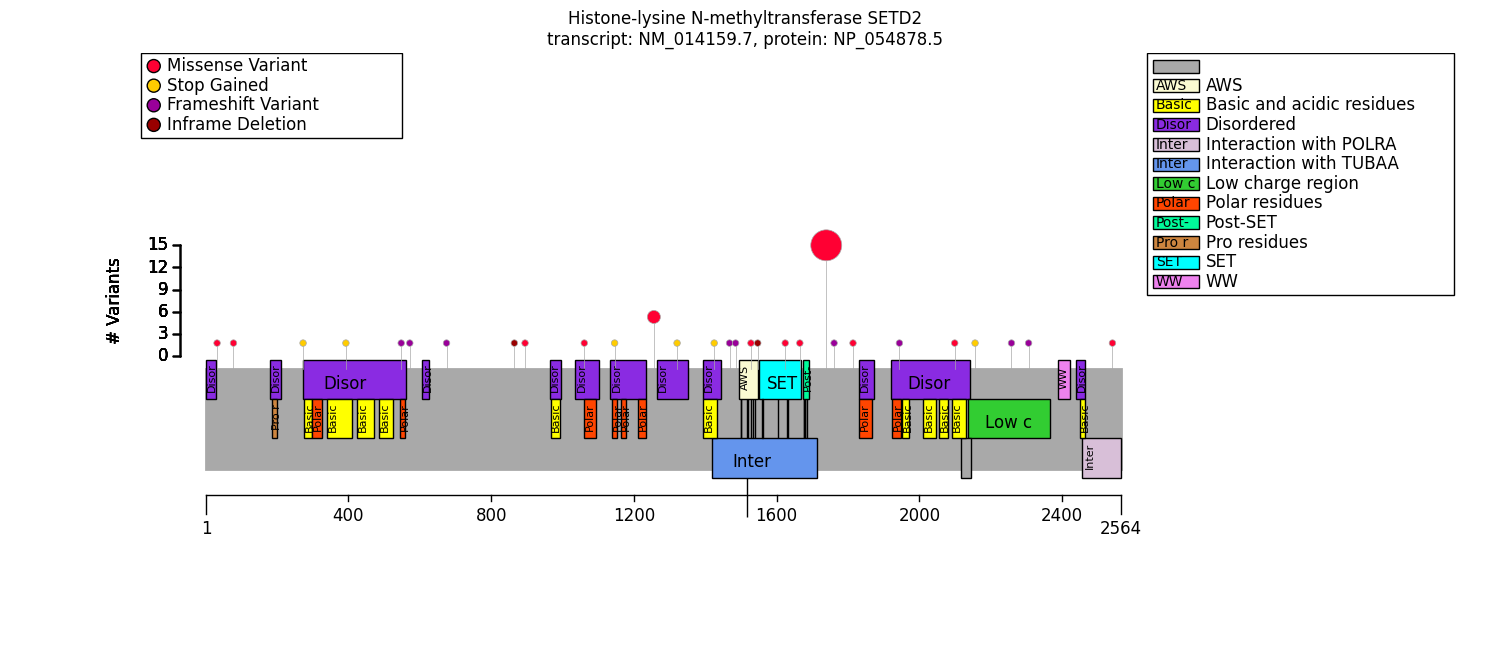

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
setd2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
setd2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_key

r1740w = variant_key(key="3_47088172_47088172_G_A") # c.5218C>T	p.Arg1740Trp	
r1740q = variant_key(key="3_47088171_47088171_C_T") # c.5219G>A	p.Arg1740Gln

r1740w_clf = monoallelic_classifier(
    a_predicate=r1740w, 
    b_predicate=~r1740w, 
    a_label="Arg1740Trp",
    b_label="Other")

r1740w_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r1740w_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(r1740w_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,74
HMF03,Skipping term because of a child term with the same individual counts,2
HMF05,Skipping term because one genotype had zero observations,3
HMF08,Skipping general term,104
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,434


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=r1740w_result)

Allele group                                       Arg1740Trp          Other  \
                                                        Count Percent  Count   
Severe global developmental delay [HP:0011344]            9/9    100%   0/12   
Hypertelorism [HP:0000316]                              11/11    100%   5/23   
Macrocephaly [HP:0000256]                                0/11      0%  19/28   
Delayed ability to walk [HP:0031936]                      8/8    100%   1/10   
Scoliosis [HP:0002650]                                    6/6    100%   2/14   
Wide nasal bridge [HP:0000431]                            9/9    100%    2/9   
Ventriculomegaly [HP:0002119]                             4/4    100%   2/17   
Motor delay [HP:0001270]                                  8/8    100%   6/13   
Global developmental delay [HP:0001263]                   9/9    100%  19/31   
Delayed speech and language development [HP:000...        8/8    100%  21/33   
Seizure [HP:0001250]                                     5/12     42%   3/25   
Premature birth [HP:0001622]                             6/12     50%   2/15   
Frontal bossing [HP:0002007]                              1/1    100%   2/23   
Hypotonia [HP:0001252]                                    2/2    100%  12/22   
Abnormality of skull size [HP:0000240]                    1/1    100%  20/20   
Abnormal axial skeleton morphology [HP:0009121]         12/12    100%  24/24   
Abnormal forehead morphology [HP:0000290]                 3/3    100%  20/20   
Abnormal brain morphology [HP:0012443]                  12/12    100%    9/9   
Morphological central nervous system abnormalit...      12/12    100%  10/10   
Neurodevelopmental delay [HP:0012758]                     9/9    100%  27/27   
Neurodevelopmental abnormality [HP:0012759]               9/9    100%  28/28   
Language impairment [HP:0002463]                          8/8    100%  21/21   
Abnormal communication [HP:0034434]                       8/8    100%  21/21   
Abnormal speech pattern [HP:0002167]                      8/8    100%  21/21   

Allele group                                                                   \
                                                   Percent Corrected p values   
Severe global developmental delay [HP:0011344]          0%           0.000082   
Hypertelorism [HP:0000316]                             22%           0.000183   
Macrocephaly [HP:0000256]                              68%           0.001162   
Delayed ability to walk [HP:0031936]                   10%           0.002468   
Scoliosis [HP:0002650]                                 14%           0.003467   
Wide nasal bridge [HP:0000431]                         22%           0.008593   
Ventriculomegaly [HP:0002119]                          12%           0.008593   
Motor delay [HP:0001270]                               46%           0.053870   
Global developmental delay [HP:0001263]                61%           0.099936   
Delayed speech and language development [HP:000...     64%           0.173913   
Seizure [HP:0001250]                                   12%           0.173913   
Premature birth [HP:0001622]                           13%           0.173913   
Frontal bossing [HP:0002007]                            9%           0.230769   
Hypotonia [HP:0001252]                                 55%           0.844720   
Abnormality of skull size [HP:0000240]                100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal forehead morphology [HP:0000290]             100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Language impairment [HP:0002463]                      10

In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
     pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Macrocephaly [HP:0000256]                              4/24     17%  15/15   
Scoliosis [HP:0002650]                                 8/13     62%    0/7   
Hypertelorism [HP:0000316]                            13/20     65%   3/14   
Hypotonia [HP:0001252]                                 5/13     38%   9/11   
Wide nasal bridge [HP:0000431]                         9/11     82%    2/7   
Prominent forehead [HP:0011220]                         1/9     11%   7/13   
Obesity [HP:0001513]                                   4/23     17%   7/16   
Intellectual disability [HP:0001249]                    2/7     29%   8/12   
Ventriculomegaly [HP:0002119]                          5/12     42%    1/9   
Delayed ability to walk [HP:0031936]                   9/15     60%    0/3   
Severe global developmental delay [HP:0011344]         9/18     50%    0/3   
Global developmental delay [HP:0001263]               15/24     62%  13/16   
Motor delay [HP:0001270]                              11/15     73%    3/6   
Autistic behavior [HP:0000729]                          4/8     50%   8/11   
Delayed speech and language development [HP:000...    17/23     74%  12/18   
Increased head circumference [HP:0040194]               4/4    100%  15/15   
Abnormality of skull size [HP:0000240]                  6/6    100%  15/15   
Abnormal axial skeleton morphology [HP:0009121]       21/21    100%  15/15   
Abnormal forehead morphology [HP:0000290]               9/9    100%  14/14   
Abnormal brain morphology [HP:0012443]                16/16    100%    5/5   
Morphological central nervous system abnormalit...    16/16    100%    6/6   
Neurodevelopmental delay [HP:0012758]                 19/19    100%  17/17   
Neurodevelopmental abnormality [HP:0012759]           20/20    100%  17/17   
Language impairment [HP:0002463]                      17/17    100%  12/12   
Abnormal communication [HP:0034434]                   17/17    100%  12/12   
Abnormal speech pattern [HP:0002167]                  17/17    100%  12/12   
Broad forehead [HP:0000337]                             3/9     33%   6/14   

Allele group                                                                   \
                                                   Percent Corrected p values   
Macrocephaly [HP:0000256]                             100%           0.000004   
Scoliosis [HP:0002650]                                  0%           0.155448   
Hypertelorism [HP:0000316]                             21%           0.155448   
Hypotonia [HP:0001252]                                 82%           0.265215   
Wide nasal bridge [HP:0000431]                         29%           0.265215   
Prominent forehead [HP:0011220]                        54%           0.334365   
Obesity [HP:0001513]                                   44%           0.533392   
Intellectual disability [HP:0001249]                   67%           0.533392   
Ventriculomegaly [HP:0002119]                          11%           0.533392   
Delayed ability to walk [HP:0031936]                    0%           0.555882   
Severe global developmental delay [HP:0011344]          0%           0.561039   
Global developmental delay [HP:0001263]                81%           0.667998   
Motor delay [HP:0001270]                               50%           0.726142   
Autistic behavior [HP:0000729]                         73%           0.726142   
Delayed speech and language development [HP:000...     67%           1.000000   
Increased head circumference [HP:0040194]             100%           1.000000   
Abnormality of skull size [HP:0000240]                100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal forehead morphology [HP:0000290]             100%           1.000000   
Abnormal brain morphology [HP:001244

In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Autistic behavior [HP:0000729]                        7/7    100%   5/12   
Broad forehead [HP:0000337]                           5/6     83%   4/17   
Ventriculomegaly [HP:0002119]                        5/10     50%   1/11   
Wide nasal bridge [HP:0000431]                       8/10     80%    3/8   
Severe global developmental delay [HP:0011344]       6/10     60%   3/11   
Intellectual disability [HP:0001249]                  2/6     33%   8/13   
Delayed speech and language development [HP:000...  11/17     65%  18/24   
Macrocephaly [HP:0000256]                            7/17     41%  12/22   
Attention deficit hyperactivity disorder [HP:00...    3/7     43%   3/13   
Scoliosis [HP:0002650]                                4/8     50%   4/12   
Motor delay [HP:0001270]                             6/10     60%   8/11   
Hypertelorism [HP:0000316]                           7/13     54%   9/21   
Global developmental delay [HP:0001263]             12/16     75%  16/24   
Increased head circumference [HP:0040194]             7/7    100%  12/12   
Abnormality of skull size [HP:0000240]                7/7    100%  14/14   
Abnormal axial skeleton morphology [HP:0009121]     14/14    100%  22/22   
Abnormal forehead morphology [HP:0000290]           10/10    100%  13/13   
Prominent forehead [HP:0011220]                       2/7     29%   6/15   
Abnormal brain morphology [HP:0012443]              12/12    100%    9/9   
Morphological central nervous system abnormalit...  12/12    100%  10/10   
Neurodevelopmental delay [HP:0012758]               14/14    100%  22/22   
Neurodevelopmental abnormality [HP:0012759]         14/14    100%  23/23   
Language impairment [HP:0002463]                    11/11    100%  18/18   
Abnormal communication [HP:0034434]                 11/11    100%  18/18   
Abnormal speech pattern [HP:0002167]                11/11    100%  18/18   
Hypotonia [HP:0001252]                                5/8     62%   9/16   
Delayed ability to walk [HP:0031936]                 6/11     55%    3/7   

Sex                                                                            \
                                                   Percent Corrected p values   
Autistic behavior [HP:0000729]                         42%           0.247140   
Broad forehead [HP:0000337]                            24%           0.247140   
Ventriculomegaly [HP:0002119]                           9%           0.571207   
Wide nasal bridge [HP:0000431]                         38%           0.977376   
Severe global developmental delay [HP:0011344]         27%           1.000000   
Intellectual disability [HP:0001249]                   62%           1.000000   
Delayed speech and language development [HP:000...     75%           1.000000   
Macrocephaly [HP:0000256]                              55%           1.000000   
Attention deficit hyperactivity disorder [HP:00...     23%           1.000000   
Scoliosis [HP:0002650]                                 33%           1.000000   
Motor delay [HP:0001270]                               73%           1.000000   
Hypertelorism [HP:0000316]                             43%           1.000000   
Global developmental delay [HP:0001263]                67%           1.000000   
Increased head circumference [HP:0040194]             100%           1.000000   
Abnormality of skull size [HP:0000240]                100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal forehead morphology [HP:0000290]             100%           1.000000   
Prominent forehead [HP:0011220]                        40%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Neurodevelopm

In [13]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis


idd70 = "OMIM:620157" # Intellectual developmental disorder, autosomal dominant 70
lls = "OMIM:616831" # Luscan-Lumish syndrome
rps = "OMIM:620155" # Rabin-Pappas syndrome
# Test onset of LLS, with 28 individuals

lls_onset = disease_onset(disease_id=lls)

survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
lls_missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=lls_onset,
)
print(f"LLS Onset vs. missense variant p={lls_missense_onset_result.pval:.5f}")

LLS Onset vs. missense variant p=0.00008


Text(2000, 0.5, '$p=0.00008$')

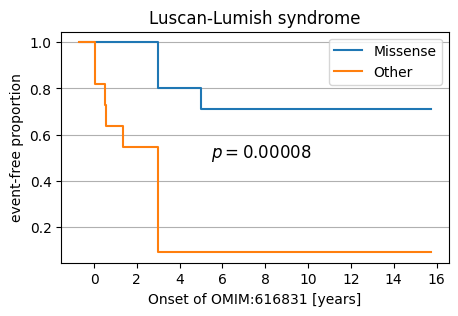

In [18]:
import matplotlib as mpl
from gpsea.model import Age

lls_onset_fig, ax = plt.subplots(figsize=(5, 3))
lls_missense_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"
_ = ax.xaxis.set(
    # Show X axis in years ...
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    # ... with a tick for every decade
    major_locator=mpl.ticker.MultipleLocator(2 * Age.DAYS_IN_YEAR),
)
_ = ax.set(
    xlabel=lls_onset.name + " [years]",
    ylabel="event-free proportion",
)
_ = ax.grid(axis="y")

ax.set_title("Luscan-Lumish syndrome")
s = f"p={lls_missense_onset_result.pval:.5f}"
ax.text(x=2000, y=0.5, s=f"${s}$", fontsize=12)

# Summary

In [19]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=r1740w_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=lls_missense_onset_result,
    ),
)

caption = "The origin of clinical diversity in patients with SEC61A1 mutation is currently unclear. With our present patient set, a particular phenotype cannot be predicted on the basis of location or nature of the mutation (PMID:32325141)."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [20]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [21]:
summarizer.process_latex(report=report, protein_fig=setd2_fig, stats_fig=lls_onset_fig)

Figure saved to ../../supplement/img/SETD2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/SETD2_stats-draft.pdf
Output to ../../supplement/tex/SETD2_summary_draft.tex
